Author: Geoff Boeing
<br />
Web: http://geoffboeing.com
<br />
Date: 2014-08-31
<br />
Description: This notebook demos how to use geopandas, shapely, and geopy. This in part borrows from the geopandas official documentation and examples

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Polygon, Point, LineString
from geopy.distance import great_circle

In [2]:
# create a GeoSeries of shapely polygon objects
p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
gs = GeoSeries([p1, p2, p3])
gs

0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object

In [3]:
# the area property of a GeoSeries will return a pandas.Series containing the area of each item in the GeoSeries
gs.area

0    0.5
1    1.0
2    1.0
dtype: float64

In [4]:
# other operations return GeoPandas objects
gs.buffer(0.5)

0    POLYGON ((-0.3535533905932737 0.35355339059327...
1    POLYGON ((-0.5 0, -0.5 1, -0.4975923633360985 ...
2    POLYGON ((1.5 0, 1.5 1, 1.502407636663901 1.04...
dtype: object

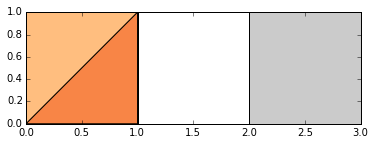

In [5]:
# GeoPandas uses descartes to generate a matplotlib plot... let's generate a plot of our GeoSeries
gs.plot()

In [6]:
# read a file containing the boroughs of New York City, using fiona under the hood
bo = GeoDataFrame.from_file('shapefiles/ny_boroughs/nybb.shp')
bo.set_index('BoroCode', inplace=True)
bo.sort()
bo

,BoroName,SHAPE_Area,SHAPE_Leng,geometry
BoroCode,,,,
1,Manhattan,6.351673e+08,339789.047314,(POLYGON ((1007193.837899998 257820.7786999941...
2,The Bronx,1.182621e+09,396753.247032,(POLYGON ((1037754.179399997 239146.6794999987...
5,Staten Island,1.613598e+09,322091.023938,(POLYGON ((967865.3023000062 161829.8024999946...
3,Brooklyn,1.995530e+09,574825.895251,(POLYGON ((1020839.574599996 191120.9502999932...
4,Queens,3.056090e+09,779241.208926,"(POLYGON ((1067127.823799998 211591.25, 106716..."


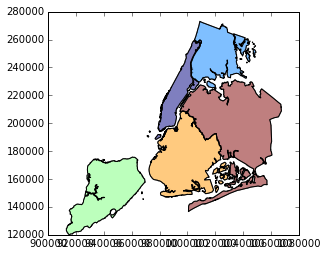

In [7]:
# plot the GeoDataFrame
bo.plot()

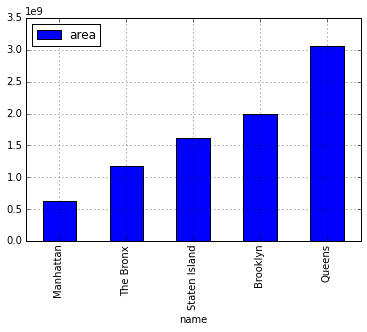

In [8]:
df = pd.DataFrame(index=bo.index, columns={})
df['area'] = bo.SHAPE_Area
df['name'] = bo.BoroName
df.index=df.name
df.plot(kind='bar')

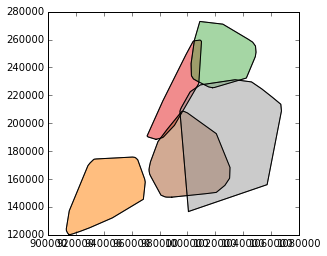

In [9]:
bo['geometry'].convex_hull.plot()

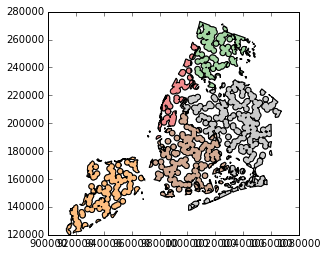

In [10]:
# generate a GeoSeries containing 2000 random points
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])

# draw a circle with fixed radius around each point
circles = pts.buffer(2000)

# collapse these circles into a single shapely MultiPolygon geometry
mp = circles.unary_union

# extract the part of this geometry contained in each borough
holes = bo['geometry'].intersection(mp)
holes.plot()

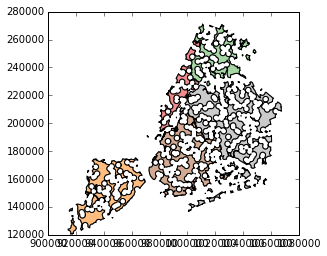

In [11]:
# calculate and plot the area that is outside of the holes
boros_with_holes = bo['geometry'].difference(mp)
boros_with_holes.plot()

In [12]:
# calculate the fractional area in each borough that are in the holes
holes.area / bo.geometry.area

BoroCode
1           0.590206
2           0.607349
5           0.577058
3           0.613854
4           0.587562
dtype: float64

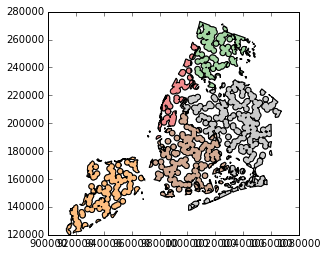

In [13]:
# the intersection method can alternatively be implemented with the '&' logical operator
(bo['geometry'] & mp).plot()

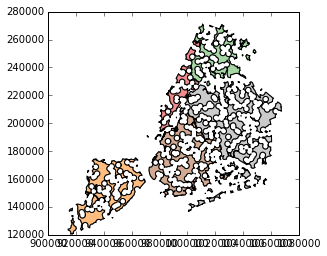

In [14]:
# the difference method can alternatively be implemented with the '-' subtraction operator
(bo['geometry'] - mp).plot()

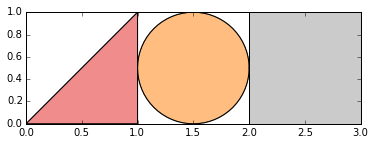

In [15]:
# create some geometries with shapely
poly1 = Polygon([(0, 0), (1, 0), (1, 1)])
poly2 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
circle = Point([(1.5, 0.5)]).buffer(0.5)

# plot a geoseries from those geometries
g = GeoSeries([poly1, circle, poly2])
g.plot()

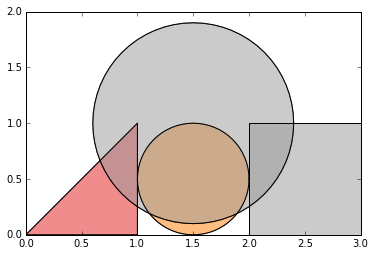

In [16]:
# create a new geoseries
big_circle = Point([1.5, 1.0]).buffer(0.9)
g.plot()
GeoSeries([big_circle]).plot()

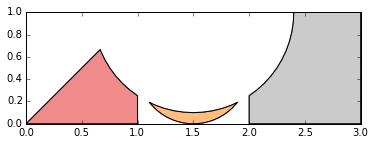

In [17]:
g.difference(big_circle).plot()

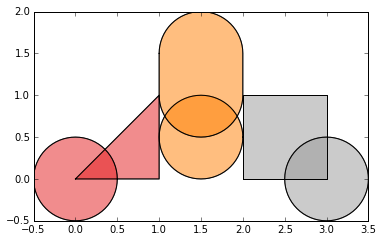

In [18]:
pts = GeoSeries([Point([0,0]), LineString([[1.5, 1], [1.5, 1.5]]), Point([3,0])])
c = pts.buffer(0.5)
g.plot()
c.plot()

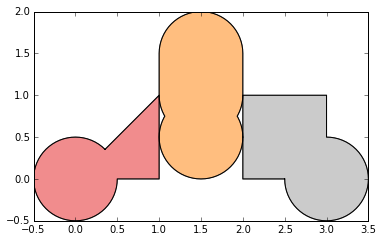

In [19]:
g.union(c).plot()

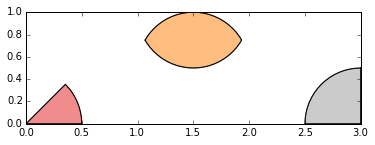

In [20]:
g.intersection(c).plot()

# Now we'll use geopandas, shapely, and geopy to manipulate and plot summer travel data

In [21]:
# load the gps coordinate data
df = pd.read_csv('data/summer-travel-gps-full.csv')
rs = pd.read_csv('data/summer-travel-gps-simplified.csv')

# load the shapefile of all countries in the world
all_countries = GeoDataFrame.from_file('shapefiles/countries_shp/world_country_admin_boundary_shapefile_with_fips_codes.shp')
all_countries.head()

,CNTRY_NAME,FIPS_CNTRY,geometry
0,Aruba,AA,POLYGON ((-69.88223266601563 12.41110992431641...
1,Antigua & Barbuda,AC,(POLYGON ((-61.7388916015625 17.54055404663086...
2,United Arab Emirates,AE,(POLYGON ((56.28047180175781 24.85727310180664...
3,Afghanistan,AF,"POLYGON ((61.27655792236328 35.60724639892578,..."
4,Algeria,AG,POLYGON ((-5.152134895324707 30.18046951293945...


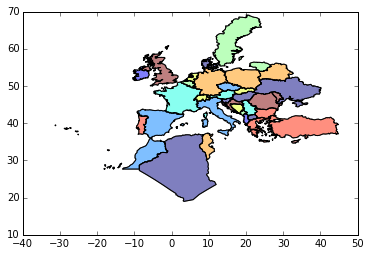

In [22]:
# define the coordinates at the extent of our point data for our map
margin_width = 4
lon_range = [rs['lon'].min() - margin_width, rs['lon'].max() + margin_width]
lat_range = [rs['lat'].min() - margin_width, rs['lat'].max() + margin_width]

# create a rectangle from these coordinates
spatial_extent = Polygon([(lon_range[0], lat_range[0]), 
                       (lon_range[0], lat_range[1]), 
                       (lon_range[1], lat_range[1]),
                       (lon_range[1], lat_range[0])])

# one way to get the shapes is with geopandas intersection, but that chops the shapes off at the extent
#countries = all_countries['geometry'].intersection(spatial_extent)
#countries.plot()

# another way to get the shapes is geopandas intersects, which pulls the full shape
# but let's remove russia because it's too big
countries = all_countries[all_countries['geometry'].intersects(spatial_extent)]
countries = countries[countries['CNTRY_NAME'] != 'Russia']
countries.plot()

In [23]:
# get a representative point for each of the most visited cities
most_index = df['city'].value_counts().head(6).index
most = pd.DataFrame(rs[rs['city'].isin(most_index)])
most.drop_duplicates(subset=['city'], take_last=False, inplace=True)

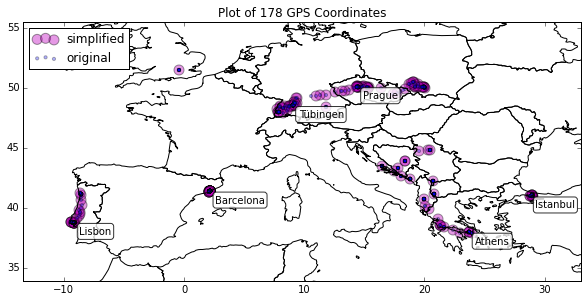

In [24]:
dimension = int((lat_range[1] - lat_range[0]) / 2)
fig = plt.figure(figsize=(dimension, dimension))

countries.plot(colormap='binary', alpha=0)

rs_scatter = plt.scatter(x=rs['lon'], y=rs['lat'], c='m', alpha=.4, s=100)
df_scatter = plt.scatter(x=df['lon'], y=df['lat'], c='b', alpha=.3, s=10)

plt.legend((rs_scatter, df_scatter), ('simplified', 'original'), loc='upper left')
plt.title('Plot of ' + str(len(rs)) + ' GPS Coordinates')

for i, row in most.iterrows():
    plt.annotate(row['city'].decode('utf-8'), 
                 xy=(row['lon'], row['lat']),
                 xytext=(row['lon'] + 0.5, row['lat'] - 1),
                 bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.8),
                 xycoords='data')

plt.xlim(lon_range)
plt.ylim(lat_range)
plt.show()